# Descriptive Analytics: Key Performance Indicators (KPIs)

Define three time-dependent KPIs that you would include in
a dashboard for the hub operator. These KPIs must provide an immediate overview of the current
hub operation and how it is doing in terms of utilization or other business-related aspects. Briefly
explain the rationale behind selecting each KPI, explain why you have chosen it and, where
needed, provide references. Calculate hourly values for the selected KPIs and visualize them over
time. Which trends do you observe? How do you explain them?

Each of these KPIs provides real-time operational insights and can be displayed in a live dashboard. They complement each other by covering different aspects of operations:

* Capacity utilization (Current Station Utilization)
* Operational efficiency (Station Turnover Rate)
* Infrastructure load (Current Power Demand)
* User experience (Estimated Wait Time)

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../cleanData/cleanChargingDataNoNull.csv')

# df = pd.read_csv('../data preparation/charging_sessions.csv')

# Convert timestamp to datetime
df['connectionTime'] = pd.to_datetime(df['connectionTime'])

# Check if duplicates have the same userID_x
same_user_duplicates = df[df.duplicated(subset=['connectionTime', 'stationID', 'siteID', 'userID_x'], keep=False)]

# Remove all same_user_duplicates from df
df = df.drop(same_user_duplicates.index)


## Current Station Utilization



### Definition
Percentage of charging stations currently in active use at any given moment

### Business Value
* Immediate visibility into resource usage
* Helps identify peak times and capacity issues
* Supports capacity planning decisions

### Target
70-85% 

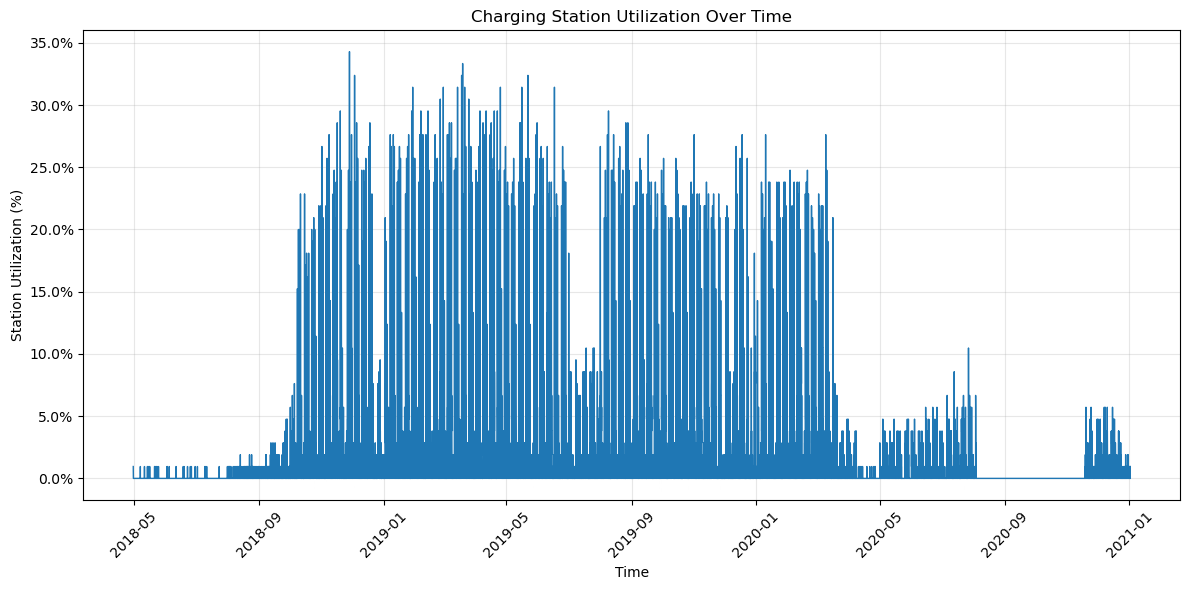

In [66]:
# Convert timestamp to datetime
df['connectionTime'] = pd.to_datetime(df['connectionTime'])

hourly_data = df.groupby(pd.Grouper(key='connectionTime', freq='h')).agg({
    'stationID': 'count'  # Count charging sessions per hour
}).reset_index()

# Get total number of unique stations
total_stations = df['stationID'].nunique()

# Calculate utilization percentage
hourly_data['utilization'] = hourly_data['stationID'] / total_stations

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(hourly_data['connectionTime'], hourly_data['utilization'], linewidth=1)

# Customize plot
plt.title('Charging Station Utilization Over Time', fontsize=12)
plt.xlabel('Time')
plt.ylabel('Station Utilization (%)')
plt.grid(True, alpha=0.3)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

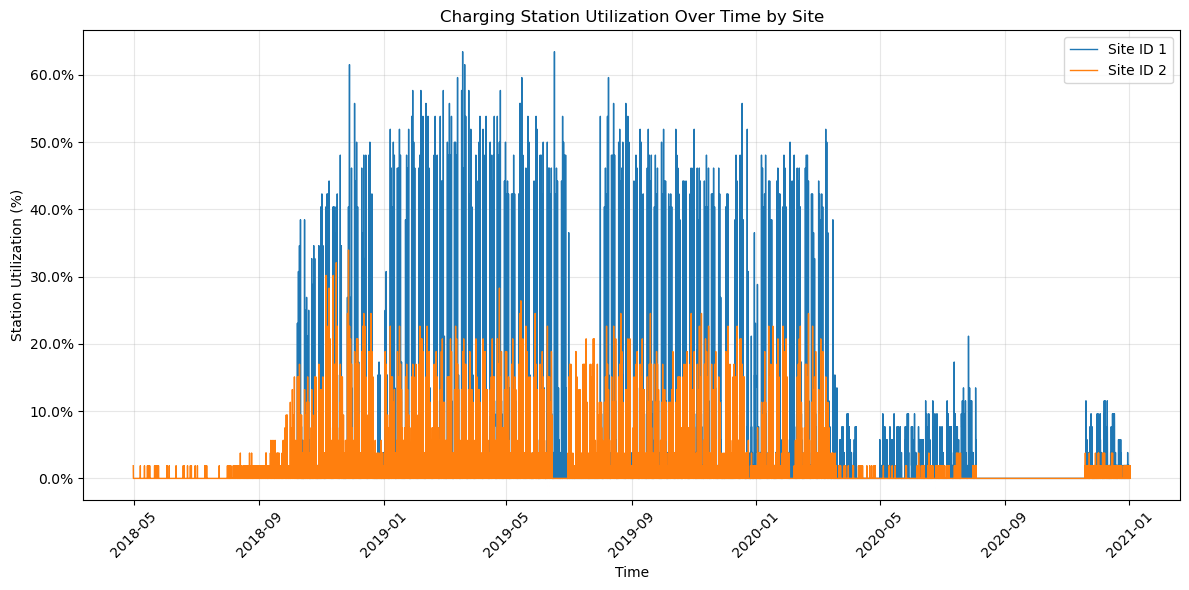

In [69]:
# Function to calculate hourly utilization for a given site ID
def calculate_utilization(df, site_id):
    site_data = df[df['siteID'] == site_id]
    hourly_data = site_data.groupby(pd.Grouper(key='connectionTime', freq='h')).agg({
        'stationID': 'count'  # Count charging sessions per hour
    }).reset_index()
    total_stations = site_data['stationID'].nunique()
    hourly_data['utilization'] = hourly_data['stationID'] / total_stations
    return hourly_data

# Calculate utilization for site ID 1 and 2
hourly_data_site1 = calculate_utilization(df, 1)
hourly_data_site2 = calculate_utilization(df, 2)

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(hourly_data_site1['connectionTime'], hourly_data_site1['utilization'], linewidth=1, label='Site ID 1')
plt.plot(hourly_data_site2['connectionTime'], hourly_data_site2['utilization'], linewidth=1, label='Site ID 2')

# Customize plot
plt.title('Charging Station Utilization Over Time by Site', fontsize=12)
plt.xlabel('Time')
plt.ylabel('Station Utilization (%)')
plt.grid(True, alpha=0.3)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Add legend
plt.legend()

plt.show()

## Station Turnover Rate

### Definition
Number of charging sessions completed per station per hour

### Business Value
* Indicates efficiency of station usage
* Helps identify potential misuse (overstaying)

### Target
0.5-1.0 sessions per station per hour (site-dependent)

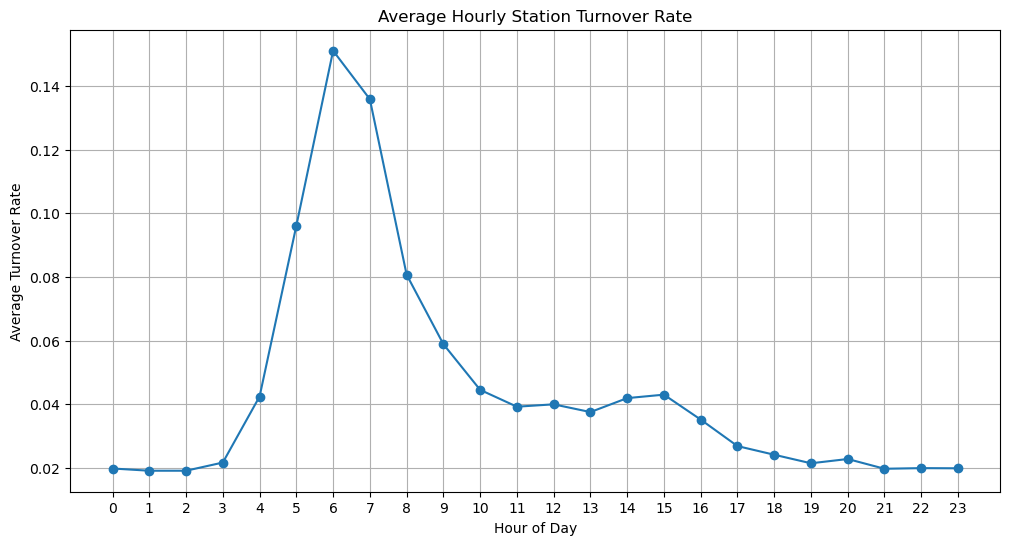

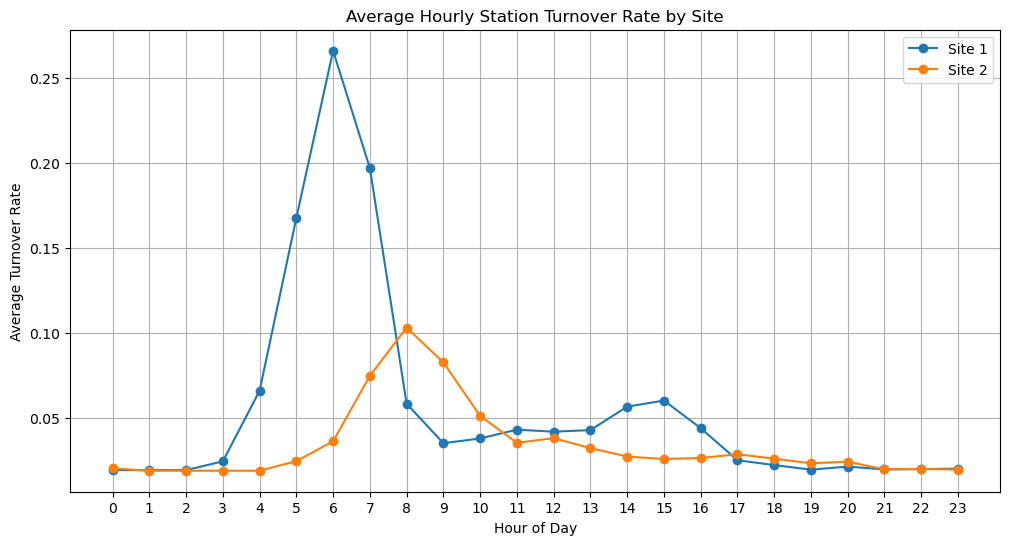

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is already loaded and 'connectionTime' is a datetime column

# First get the number of stations per site
stations_per_site = df.groupby('siteID')['stationID'].nunique()

# Create date and hour columns first
df['date'] = df['connectionTime'].dt.date
df['hour'] = df['connectionTime'].dt.hour

# Now group by these new columns
hourly_sessions = df.groupby(['siteID', 'date', 'hour']).size().reset_index(name='completed_sessions')

# Calculate turnover rate
hourly_sessions['turnover_rate'] = hourly_sessions.apply(
    lambda x: x['completed_sessions'] / stations_per_site[x['siteID']], 
    axis=1
)

# Calculate average turnover rate by hour for each site
avg_hourly_turnover = hourly_sessions.groupby(['siteID', 'hour'])['turnover_rate'].mean().reset_index()

# Plot average patterns for the whole dataset
plt.figure(figsize=(12, 6))
plt.plot(avg_hourly_turnover.groupby('hour')['turnover_rate'].mean(), marker='o')
plt.title('Average Hourly Station Turnover Rate')
plt.xlabel('Hour of Day')
plt.ylabel('Average Turnover Rate')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

# Plot average patterns for siteID 1 and siteID 2
plt.figure(figsize=(12, 6))
for site in [1, 2]:
    site_data = avg_hourly_turnover[avg_hourly_turnover['siteID'] == site]
    plt.plot(site_data['hour'], site_data['turnover_rate'], 
             label=f'Site {site}', marker='o')

plt.title('Average Hourly Station Turnover Rate by Site')
plt.xlabel('Hour of Day')
plt.ylabel('Average Turnover Rate')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

## Current Power Demand

### Definition
Total power currently being drawn by all active charging sessions

### Business Value
* Grid load management
* Peak demand monitoring
* Energy cost optimization

### Target
Below site's maximum power capacity (<80% of total capacity)

In [ ]:
active_sessions = df[(df['connectionTime'] <= current_time) & 
                    (df['disconnectTime'] > current_time)]
current_power = sum(active_sessions['kWhDelivered'] / 
                   active_sessions['parkDuration'].dt.hours)

## Estimated Wait Time

### Definition
Expected time until next available charging station

### Business Value
* Customer experience management
* Queue management
* Real-time user communication

### Target
< 15 minutes during peak hours, 0 minutes during off-peak

In [ ]:
if current_utilization < 100%:
    wait_time = 0
else:
    wait_time = min(df[df['doneChargingTime'] > current_time]
                   ['doneChargingTime']) - current_time

---

These KPIs could be displayed side-by-side for comparison, which might help identify patterns unique to each type of site (e.g., longer sessions but lower turnover at the private site vs. shorter sessions and higher turnover at the public site).